In [59]:
import os
import random
import warnings

# Dataframe
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error

import optuna
from optuna import Trial
from sklearn.model_selection import ParameterGrid

warnings.filterwarnings('ignore')

In [2]:
start_date = '2010-01-01'
end_date = '2022-12-31'

In [137]:
data = pd.read_csv('./data/kospi.csv').dropna()
data = data[data['Date'] <= end_date]
data['Change'] = data['Kospi'].pct_change() * 100
data.loc[0, 'Change'] = 0
data

,Date,Kospi,USD/KRW,GDP,IAIP,LIR,M1,disease,Change
0,2010-01-04,1696.140015,1132.400024,1143.67,79.3,5.350,59.71815,0,0.000000
1,2010-01-05,1690.619995,1141.300049,1143.67,79.3,5.350,59.71815,0,-0.325446
2,2010-01-06,1705.319946,1130.400024,1143.67,79.3,5.350,59.71815,0,0.869501
3,2010-01-07,1683.449951,1134.900024,1143.67,79.3,5.350,59.71815,0,-1.282457
4,2010-01-08,1695.260010,1123.099976,1143.67,79.3,5.350,59.71815,0,0.701539
...,...,...,...,...,...,...,...,...,...
3198,2022-12-23,2313.689941,1290.199951,1673.92,126.0,3.541,193.79220,0,-1.826261
3199,2022-12-26,2317.139893,1279.239990,1673.92,126.0,3.541,193.79220,0,0.149110
3200,2022-12-27,2332.790039,1275.130005,1673.92,126.0,3.541,193.79220,0,0.675408
3201,2022-12-28,2280.449951,1272.280029,1673.92,126.0,3.541,193.79220,0,-2.243669


In [4]:
split_date = '2021-12-31'

# train, valid, test 데이터 나누기
train_data = data.loc[data['Date'] <= split_date].copy()
test_data = data.loc[data['Date'] > split_date].copy()

In [5]:
print("Train 데이터 크기:", len(train_data))
print("Test 데이터 크기:", len(test_data))

Train 데이터 크기: 2959
Test 데이터 크기: 244


In [6]:
data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

train_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
train_data['ds'] = pd.to_datetime(train_data['ds'])

test_data.rename(columns={'Date': 'ds', 'Kospi': 'y'}, inplace=True)
test_data['ds'] = pd.to_datetime(test_data['ds'])

In [7]:
regressor_columns = ['USD/KRW', 'GDP', 'IAIP', 'LIR', 'M1', 'disease']

# 가능한 모든 조합의 리스트 생성
all_combinations = []
for r in range(1, len(regressor_columns) + 1):
    all_combinations.extend(combinations(regressor_columns, r))

regressor_combinations = ['_'.join(combination) for combination in all_combinations]

In [72]:
train_data.iloc[:, :2]

,ds,y
0,2010-01-04,1696.140015
1,2010-01-05,1690.619995
2,2010-01-06,1705.319946
3,2010-01-07,1683.449951
4,2010-01-08,1695.260010
...,...,...
2954,2021-12-24,3012.429932
2955,2021-12-27,2999.550049
2956,2021-12-28,3020.239990
2957,2021-12-29,2993.290039


04:27:18 - cmdstanpy - INFO - Chain [1] start processing
04:27:19 - cmdstanpy - INFO - Chain [1] done processing


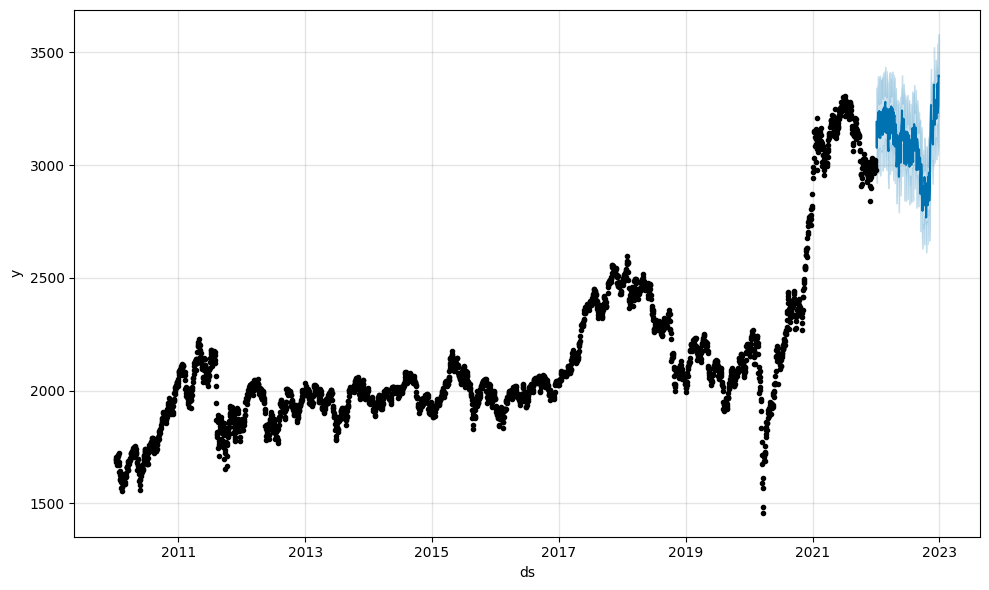

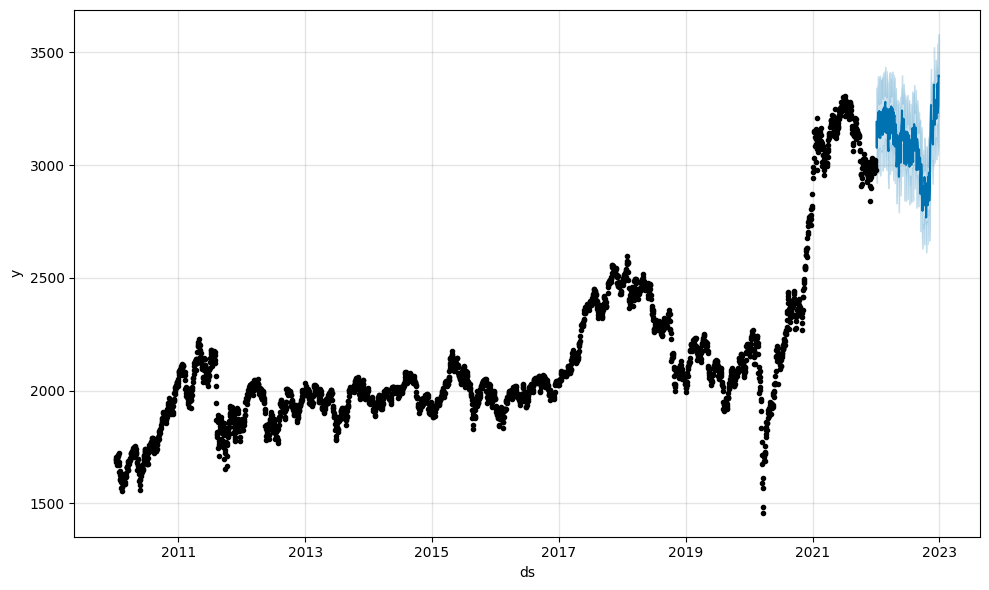

In [131]:
m = Prophet(changepoints=['2015-12-23', '2015-05-20', '2020-01-20'])

regressor_columns = ['USD/KRW', 'disease']

for col in regressor_columns:
    m.add_regressor(col)
m.fit(train_data)

future = m.make_future_dataframe(periods=len(test_data), include_history=False)

for col in regressor_columns:
    future[col] = test_data[col].values

forecast = m.predict(future)
forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]
m.plot(forecast)

In [8]:
def train(train_data, changepoint_prior_scale, n_changepoints, seasonality_mode,regressors=[]):
    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        n_changepoints=n_changepoints,
        seasonality_mode=seasonality_mode,
        growth='linear',
    )
    
    columns = regressors.split('_')
    
    for col in columns:
        model.add_regressor(col)
    
    model.fit(train_data)
    train_cv = cross_validation(model, initial=f'2070 days', period='90 days', horizon='30 days', disable_tqdm=True)
    
    train_p = performance_metrics(train_cv)
    
    return model, train_cv, train_p

In [9]:
def test(model: Prophet, test_data, regressors=[], **kwargs):
    columns = regressors.split('_')
    
    # 예측 및 평가
    future = model.make_future_dataframe(periods=len(test_data), include_history=False)
    
    for col in columns:
        future[col] = test_data[col].values
    
    forecast = model.predict(future)
    rmse = np.sqrt(mean_squared_error(test_data["y"], forecast["yhat"]))

    return rmse, forecast

In [10]:
def objective(trial: Trial) -> float:
    # 하이퍼파라미터 설정
    changepoint_prior_scale = trial.suggest_categorical("changepoint_prior_scale", [0.1, 0.2, 0.3, 0.4, 0.5])
    n_changepoints = trial.suggest_categorical("n_changepoints", [100, 150, 200])
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
    regressors = trial.suggest_categorical("regressors", regressor_combinations)

    params = {'changepoint_prior_scale': changepoint_prior_scale, 'n_changepoints': n_changepoints, 'seasonality_mode': seasonality_mode, 'regressors': regressors}
    
    _, _, train_p = train(train_data, **params)
    rmse = round(train_p["rmse"].mean(),1)
    
    return rmse

In [11]:
params_grid = {
    "changepoint_prior_scale": [0.1, 0.2, 0.3, 0.4, 0.5],
    "n_changepoints": [100, 150, 200],
    "seasonality_mode": ["additive", "multiplicative"],
    "regressors": regressor_combinations
}
grid = ParameterGrid(params_grid)

cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 1890


In [12]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

best_params = study.best_params
print(f"최적의 하이퍼파라미터: {best_params}")

[I 2024-04-11 18:43:00,221] A new study created in memory with name: no-name-fbe74920-203d-4e53-a7db-ecdf1bd4fa0a
18:43:00 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing
18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
18:43:55 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing
18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing
18:44:27 - cmdstanpy - INFO - Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] done processing
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
18:44:52 - cmdstanpy - INFO - Chain [1

최적의 하이퍼파라미터: {'changepoint_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive', 'regressors': 'LIR_M1_disease'}


In [13]:
model, train_cv, train_p = train(train_data, **best_params)

22:02:09 - cmdstanpy - INFO - Chain [1] start processing
22:02:30 - cmdstanpy - INFO - Chain [1] done processing
22:02:30 - cmdstanpy - INFO - Chain [1] start processing
22:02:36 - cmdstanpy - INFO - Chain [1] done processing
22:02:36 - cmdstanpy - INFO - Chain [1] start processing
22:02:42 - cmdstanpy - INFO - Chain [1] done processing
22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:48 - cmdstanpy - INFO - Chain [1] done processing
22:02:48 - cmdstanpy - INFO - Chain [1] start processing
22:02:55 - cmdstanpy - INFO - Chain [1] done processing
22:02:55 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:11 - cmdstanpy - INFO - Chain [1] done processing
22:03:11 - cmdstanpy - INFO - Chain [1] start processing
22:03:21 - cmdstanpy - INFO - Chain [1] done processing
22:03:21 - cmdstanpy - INFO - Chain [1] start processing
22:03:31 - cmdstanpy - INFO - Chain [1]

In [14]:
train_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-10-05,1907.147964,1868.882994,1945.400351,1978.250000,2015-10-03
1,2015-10-06,1905.939912,1868.188983,1946.487436,1990.650024,2015-10-03
2,2015-10-07,1904.593843,1867.855089,1944.975664,2005.839966,2015-10-03
3,2015-10-08,1902.705195,1861.001651,1942.551902,2019.530029,2015-10-03
4,2015-10-12,1894.901209,1855.225570,1935.210618,2021.630005,2015-10-03
...,...,...,...,...,...,...
515,2021-12-24,3300.593145,3189.703787,3411.941286,3012.429932,2021-11-30
516,2021-12-27,3294.480502,3179.578941,3409.963958,2999.550049,2021-11-30
517,2021-12-28,3295.737943,3182.842298,3402.449460,3020.239990,2021-11-30
518,2021-12-29,3295.300963,3186.503362,3415.620880,2993.290039,2021-11-30


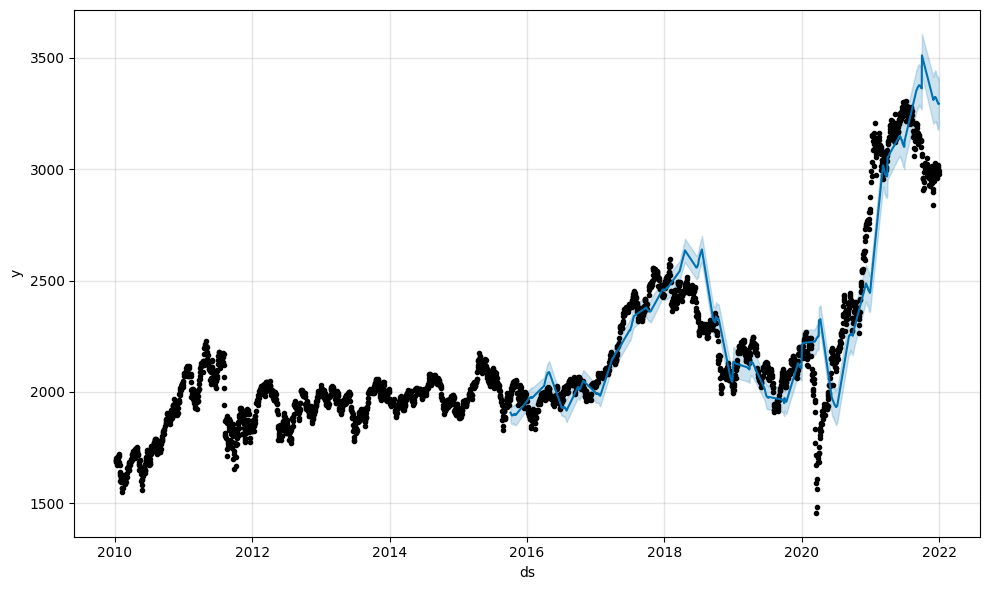

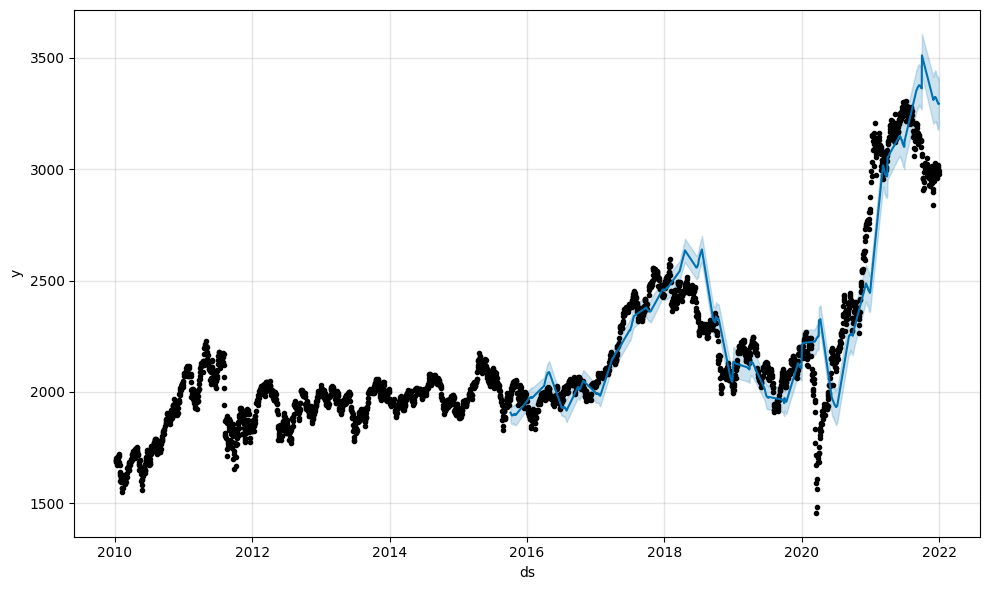

In [15]:
model.plot(train_cv)

In [16]:
train_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,28142.670324,167.757773,117.641903,0.050751,0.031309,0.049498,0.375566
1,4 days,23939.815790,154.724968,110.084972,0.047821,0.034250,0.047209,0.346154
2,5 days,16813.183191,129.665659,93.996399,0.040536,0.032884,0.040529,0.357906
3,6 days,19381.134763,139.216144,102.098956,0.043798,0.037300,0.043464,0.300481
4,7 days,26929.098885,164.100880,116.192797,0.051091,0.035433,0.049351,0.308704
5,8 days,38169.385506,195.369868,137.279707,0.062078,0.038581,0.058750,0.269231
6,9 days,47410.245692,217.738939,150.867565,0.070306,0.040518,0.065563,0.258547
7,10 days,52236.949102,228.554040,159.237895,0.075218,0.050974,0.070146,0.253205
8,11 days,43160.839653,207.751870,144.924303,0.067653,0.044912,0.064275,0.280048
9,12 days,27509.390126,165.859549,120.407833,0.053532,0.042409,0.052656,0.311298


In [17]:
print("RMSE: ", round(train_p["rmse"].mean(),1))
print("MAPE: ", 100 * round(train_p["mape"].mean(),3), "%")

RMSE:  186.9
MAPE:  6.1 %


In [83]:
rmse, forecast = test(model, test_data, **best_params)

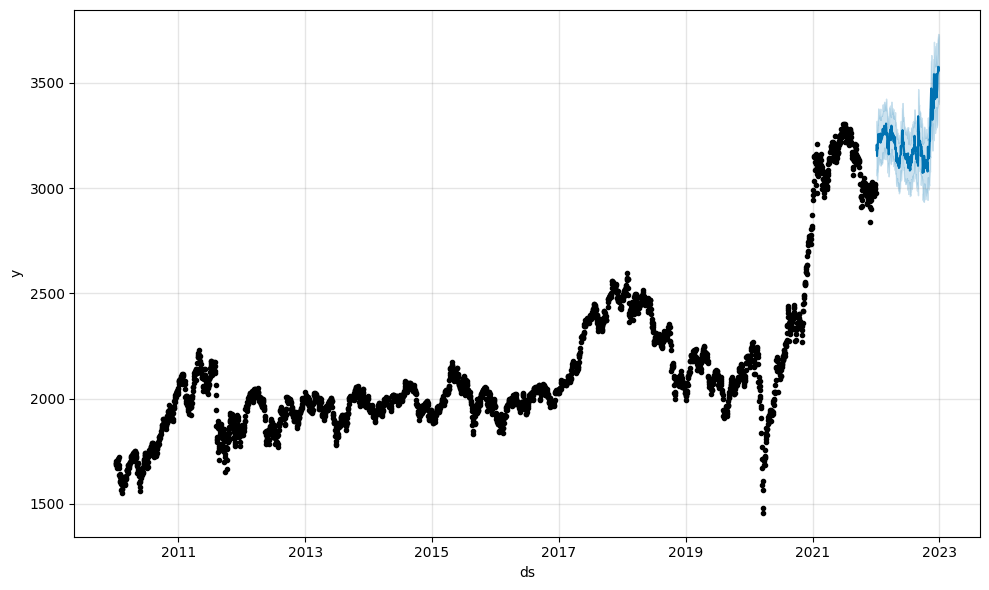

In [119]:
fig = model.plot(forecast)

In [19]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,LIR,LIR_lower,LIR_upper,M1,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-31,-1462.607263,3154.348981,3376.791464,-1462.607263,-1462.607263,-49.292684,-49.292684,-49.292684,4784.890928,...,324.338740,324.338740,324.338740,-13.727052,-13.727052,-13.727052,0.0,0.0,0.0,3262.507801
1,2022-01-01,-1465.129711,2016.194625,2240.057189,-1465.129711,-1465.129711,-49.292684,-49.292684,-49.292684,4784.890928,...,-810.677784,-810.677784,-810.677784,-10.302720,-10.302720,-10.302720,0.0,0.0,0.0,2128.393161
2,2022-01-02,-1467.652160,2004.513926,2236.491985,-1467.652160,-1467.652160,-49.292684,-49.292684,-49.292684,4784.890928,...,-810.677225,-810.677225,-810.677225,-6.594912,-6.594912,-6.594912,0.0,0.0,0.0,2129.579078
3,2022-01-03,-1470.174608,3152.106350,3375.442493,-1470.174608,-1470.174608,-49.292684,-49.292684,-49.292684,4784.890928,...,322.730664,322.730664,322.730664,-2.630735,-2.630735,-2.630735,0.0,0.0,0.0,3264.428697
4,2022-01-04,-1472.697057,3153.655190,3375.649625,-1472.697057,-1472.697057,-49.292684,-49.292684,-49.292684,4784.890928,...,325.122606,325.122606,325.122606,1.557890,1.557890,1.557890,0.0,0.0,0.0,3268.486816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,2022-08-27,-2065.472447,678.142255,1430.997183,-2417.190685,-1733.478969,150.165337,150.165337,150.165337,3849.267088,...,-810.677784,-810.677784,-810.677784,-47.553488,-47.553488,-47.553488,0.0,0.0,0.0,1075.728707
240,2022-08-28,-2067.994895,712.055988,1433.257553,-2421.908512,-1735.571238,150.165337,150.165337,150.165337,3849.267088,...,-810.677225,-810.677225,-810.677225,-47.326217,-47.326217,-47.326217,0.0,0.0,0.0,1073.434087
241,2022-08-29,-2070.517344,1816.349243,2545.757338,-2426.325324,-1736.406111,150.165337,150.165337,150.165337,3849.267088,...,322.730664,322.730664,322.730664,-46.868210,-46.868210,-46.868210,0.0,0.0,0.0,2204.777536
242,2022-08-30,-2073.039792,1813.424995,2553.223838,-2430.742135,-1736.725347,150.165337,150.165337,150.165337,3849.267088,...,325.122606,325.122606,325.122606,-46.193303,-46.193303,-46.193303,0.0,0.0,0.0,2205.321936


In [20]:
forecast['ds'].iloc[:] = pd.to_datetime(test_data['ds']).iloc[:]

In [98]:
temp = data[data['ds'] > '2021']

In [22]:
def plot_stock_forecast(data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')
    plt.plot(pd.to_datetime(data['ds']), data['y'], label='Actual', color='blue')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.5)
    plt.title('Stock Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

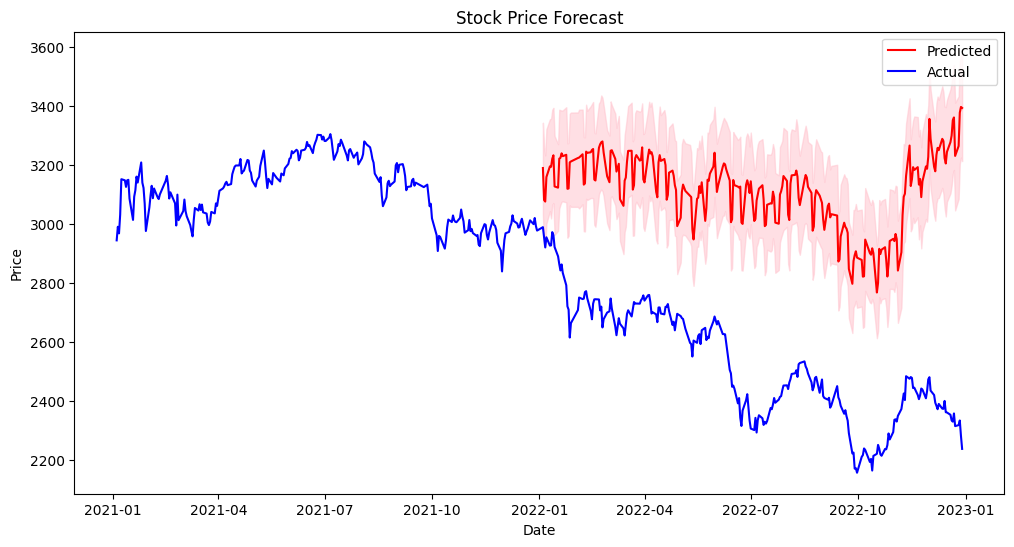

In [134]:
plot_stock_forecast(temp, forecast)

In [65]:
def printResult(test_datelist, test_true, test_forecast):
    test_result_list = []
    for date in test_datelist:
        test_result_list.append([date, test_true[date], test_forecast[date]])
    test_yyyymm = []
    test_start_y = test_result_list[0][0].year
    test_end_y = test_result_list[-1][0].year
    test_start_m = test_result_list[0][0].month
    test_end_m = test_result_list[-1][0].month
    
    if (test_start_y == test_end_y):
        for i in range(test_start_m, test_end_m + 1):
            test_yyyymm.append(test_start_y * 100 + i)
    else:
        for i in range(test_end_y - test_start_y + 1):
            if (i == 0):
                for j in range(test_start_m, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            elif (i == (test_end_y - test_start_y)):
                for j in range(1, test_end_m + 1):
                    test_yyyymm.append((test_start_y + i) * 100 + j)
            else:
                for j in range(1, 13):
                    test_yyyymm.append((test_start_y + i) * 100 + j) 
                    
    test_month_tf = {}
    errorRates = []
    for i in range(len(test_yyyymm)):
        test_month_tf[test_yyyymm[i]] = [0, 0]
    for i in range(len(test_result_list)):
        key = test_result_list[i][0].year * 100 + test_result_list[i][0].month
        test_month_tf[key][0] += test_result_list[i][1]
        test_month_tf[key][1] += test_result_list[i][2]
        
    for i in range(len(test_month_tf)):
        printYear = int(test_yyyymm[i] // 100)
        printMonth = int(test_yyyymm[i] % 100)
        printTrue = int(test_month_tf[test_yyyymm[i]][0])
        printForecast = round(test_month_tf[test_yyyymm[i]][1])
        printDiff = printTrue - printForecast
        errorRate = round(abs(printTrue - printForecast) / printTrue * 100, 2)
        print('[{0}년 {1}월] | 실제 코스피 지수: {2}원    | 예상 코스피 지수: {3}원       | 차이: {4}원       | 절대 오차율: {5}%'.format(printYear, printMonth, printTrue, printForecast, printDiff, errorRate))
        errorRates.append(errorRate)
    print(f'평균 오차율: {round(sum(errorRates)/len(errorRates), 2)}')

In [56]:
test_datelist = test_data['ds'].to_list()
test_true = test_data.set_index('ds')['y']
test_forecast = forecast.set_index('ds')['yhat']

In [57]:
test_true[test_datelist[0]]

2989.23999

In [66]:
printResult(test_data['ds'].to_list(), test_true, test_forecast)

[2022년 1월] | 실제 코스피 지수: 54322원    | 예상 코스피 지수: 55464원       | 차이: -1142원       | 절대 오차율: 2.1%
[2022년 2월] | 실제 코스피 지수: 49032원    | 예상 코스피 지수: 54959원       | 차이: -5927원       | 절대 오차율: 12.09%
[2022년 3월] | 실제 코스피 지수: 56673원    | 예상 코스피 지수: 63853원       | 차이: -7180원       | 절대 오차율: 12.67%
[2022년 4월] | 실제 코스피 지수: 56768원    | 예상 코스피 지수: 63540원       | 차이: -6772원       | 절대 오차율: 11.93%
[2022년 5월] | 실제 코스피 지수: 52584원    | 예상 코스피 지수: 60997원       | 차이: -8413원       | 절대 오차율: 16.0%
[2022년 6월] | 실제 코스피 지수: 49498원    | 예상 코스피 지수: 60364원       | 차이: -10866원       | 절대 오차율: 21.95%
[2022년 7월] | 실제 코스피 지수: 49618원    | 예상 코스피 지수: 57527원       | 차이: -7909원       | 절대 오차율: 15.94%
[2022년 8월] | 실제 코스피 지수: 54550원    | 예상 코스피 지수: 56688원       | 차이: -2138원       | 절대 오차율: 3.92%
[2022년 9월] | 실제 코스피 지수: 46678원    | 예상 코스피 지수: 55909원       | 차이: -9231원       | 절대 오차율: 19.78%
[2022년 10월] | 실제 코스피 지수: 42375원    | 예상 코스피 지수: 49431원       | 차이: -7056원       | 절대 오차율: 16.65%
[2022년 11월] | 실제 코스피 지수: 53186원    | 예상 코스